# **Predicting Teamfight Tactics Results with Machine Learning Techniques**

Teamfight Tactics (TFT) is an online auto-battler from Riot Games. With such a vast playerbase, this game generates massive amounts of data which as mentioned in Introduction is a den for testing ML techniques to predict an outcome of a game.

The project explores the relationships between different augments, champions and items within a team as a decisive factor in a win rather just the team composition. Hence, from supervised learning, there were implemented regression models to predict a continuous variable (placement) and classification models to predict a discrete variable (win/loss). The objective is to find which model has the best accuracy.


# **Setting up**

## **Import needed libraries**

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Selected Model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score

### **Load Data**

In [46]:
data = pd.read_csv('data/final.csv')

## **Analyze Data**

### **Check missing values**

In [47]:
# Check for missing values
missing_values = data.isnull().sum().sum()

# Display any missing values
missing_values

0

### **Target (Placement) distribution**

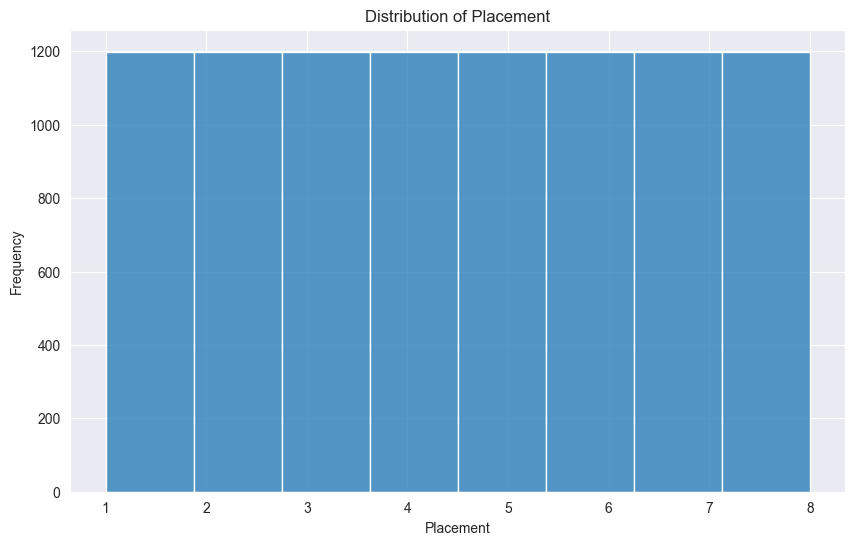

In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(data['placement'], bins=8, kde=False)
plt.title('Distribution of Placement')
plt.xlabel('Placement')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram of the placement column shows a fairly uniform distribution across different placement ranks from 1 to 8, which suggests that the data covers all placement outcomes well.

### **Correlation heatmap**

In [49]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Get the absolute correlation values with 'placement'
correlation_with_placement = corr_matrix['placement'].abs()

# Sort the attributes by decreasing correlation values, excluding 'placement'
sorted_correlation = correlation_with_placement.sort_values(ascending=False)

# Select the top 30 features, including 'placement'
top_features = sorted_correlation.index[:30]

# Creat new correlation heatmap 
corr_matrix_cleaned = corr_matrix.loc[top_features, top_features]

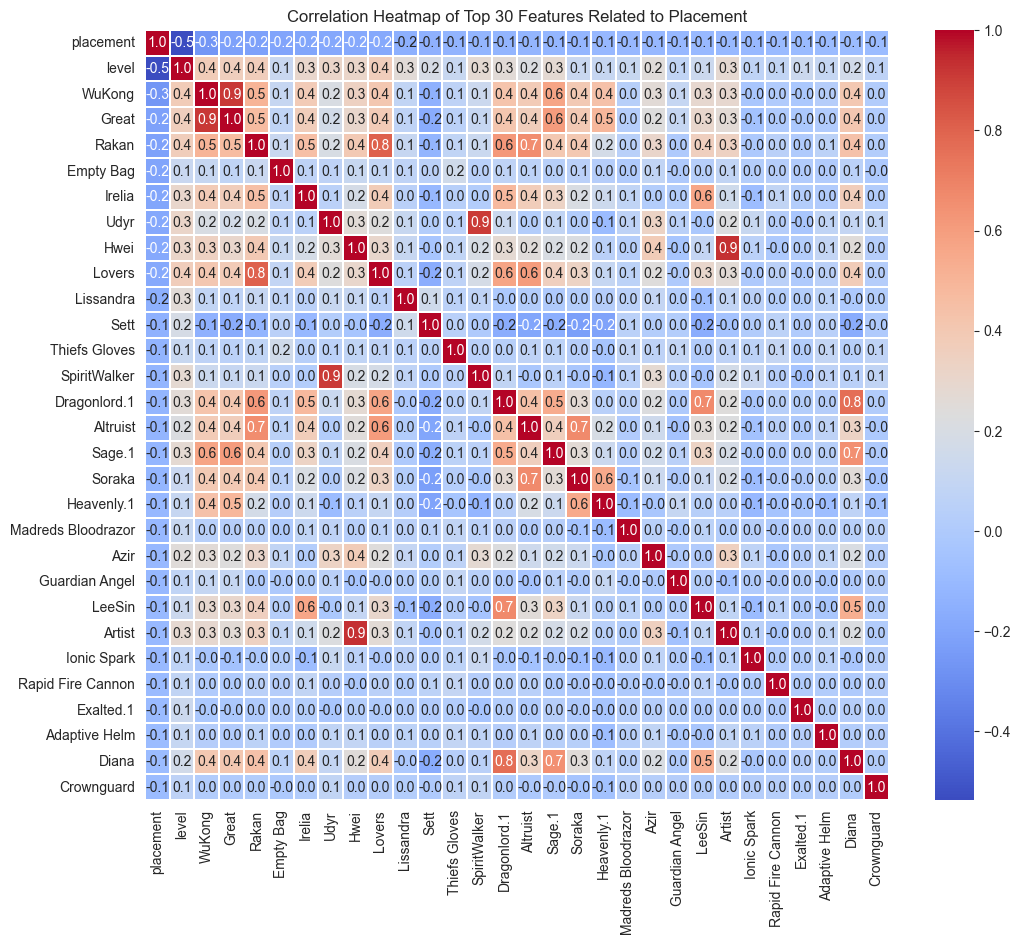

In [50]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_cleaned, cmap='coolwarm', linewidths=0.1, annot=True, fmt=".1f")
plt.title('Correlation Heatmap of Top 30 Features Related to Placement')
plt.show()

In [51]:
# Find the top 10 features that correlate most strongly with 'placement'
top_correlations = corr_matrix_cleaned['placement'].abs().sort_values(ascending=False).head(11)

# Show the top correlating features
top_correlations 

placement    1.000000
level        0.537287
WuKong       0.261975
Great        0.215193
Rakan        0.213714
Empty Bag    0.203367
Irelia       0.197702
Udyr         0.187076
Hwei         0.177519
Lovers       0.177139
Lissandra    0.152256
Name: placement, dtype: float64

In [52]:
# Initialize a dictionary to store the top correlated features for each feature
top_correlated_pairs = {}

# Loop through each column in the correlation matrix
for feature in corr_matrix_cleaned.columns:
    # Get the absolute correlation values with other features
    correlations = corr_matrix_cleaned[feature].sort_values(ascending=False)
    
    # Exclude the feature itself
    correlations = correlations.drop(index=feature)
    
    # Select the top 5 correlated features
    top_correlated_pairs[feature] = correlations.head(5)

# Display the top correlated pairs for each feature
for feature, top_correlated in top_correlated_pairs.items():
    print(f"Top 5 correlated features with '{feature}':")
    print(top_correlated)
    print()


Top 5 correlated features with 'placement':
Crownguard          -0.087417
Diana               -0.091846
Adaptive Helm       -0.092372
Exalted.1           -0.096563
Rapid Fire Cannon   -0.096771
Name: placement, dtype: float64

Top 5 correlated features with 'level':
WuKong    0.379071
Lovers    0.368642
Rakan     0.365003
Great     0.358702
Hwei      0.315028
Name: level, dtype: float64

Top 5 correlated features with 'WuKong':
Great           0.913123
Sage.1          0.571906
Rakan           0.505090
Heavenly.1      0.437840
Dragonlord.1    0.427698
Name: WuKong, dtype: float64

Top 5 correlated features with 'Great':
WuKong          0.913123
Sage.1          0.608584
Heavenly.1      0.494316
Rakan           0.466601
Dragonlord.1    0.414180
Name: Great, dtype: float64

Top 5 correlated features with 'Rakan':
Lovers          0.803849
Altruist        0.658131
Dragonlord.1    0.617157
WuKong          0.505090
Great           0.466601
Name: Rakan, dtype: float64

Top 5 correlated features

## **Classification Model**

**Preparation Data**

In [53]:
# Convert 'placement' into binary classification target
# 1-4 will be 1 ('win'), 5-8 will be 0 ('loss')
data['placement'] = data['placement'].apply(lambda x: 1 if x <= 4 else 0)   

# Define features (X) and target (y)
X = data.drop(columns=['placement'])
y = data['placement']

**Training and Test sets**

In [54]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = (train_test_split(X, y,test_size=1/3, random_state=32))

### **Naive Bayes Model**

In [55]:
# Initialize the models
naive_bayes_model = MultinomialNB()
# Train the Naive Bayes model
naive_bayes_model.fit(X_train, y_train)
# Predictions for Naive Bayes
y_pred_naive_bayes = naive_bayes_model.predict(X_test)
# Evaluate the Naive Bayes model
accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes)

### **Logistic Regression Model**

In [56]:
# Initialize the models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression model
logistic_model.fit(X_train, y_train)

# Predictions for Logistic Regression
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)

In [57]:
accuracy_logistic

0.7998749218261413

In [58]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}

# Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

C:\Users\Hoang Tu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hoang Tu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best cross-validation score: 0.81


### **Support Vector Machine Model**

In [59]:
# Initialize the Support Vector Machine model
svm_model = SVC(random_state=42)

# Train the SVM model
svm_model.fit(X_train, y_train)

# Predictions for SVM
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

## **Regression Model**

### **Linear Regression Model**

In [60]:
# Creating a linear regression model
linear_reg = LinearRegression()

# Training the model
linear_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = linear_reg.predict(X_test)

# Calculating the mean squared error and R-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Range value of linear model regression

In [61]:
min(y_pred), max(y_pred)

(-1.7532775993000407, 1.681033109099599)

### **Support Vector Regression Model**

In [62]:
# Create and train the SVR model with a linear kernel
svr_linear = SVR(kernel='linear')
svr_linear.fit(X_train, y_train)

# Predict on the test set using SVR
y_pred_svr = svr_linear.predict(X_test)

# Calculating metrics for SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

Range value of Support Vector Regression model

In [63]:
min(y_pred_svr), max(y_pred_svr)

(-2.2084714364694875, 1.888628151935448)

### **Performance Comparison**

In [64]:
def calculate_errors(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    return train_error, test_error

In [65]:
# Calculate errors for all models
train_error_logistic, test_error_logistic = calculate_errors(logistic_model, X_train, y_train, X_test, y_test)
train_error_naive_bayes, test_error_naive_bayes = calculate_errors(naive_bayes_model, X_train, y_train, X_test, y_test)
train_error_svm, test_error_svm = calculate_errors(svm_model, X_train, y_train, X_test, y_test)
train_error_linear, test_error_linear = calculate_errors(linear_reg, X_train, y_train, X_test, y_test)
train_error_svr, test_error_svr = calculate_errors(svr_linear, X_train, y_train, X_test, y_test)

# Print train and test errors for all models
print("Train and Test Errors for all models:")
print("Logistic Regression - Train Error:", train_error_logistic, "Test Error:", test_error_logistic)
print("Naive Bayes - Train Error:", train_error_naive_bayes, "Test Error:", test_error_naive_bayes)
print("SVM - Train Error:", train_error_svm, "Test Error:", test_error_svm)
print("Linear Regression - Train Error:", train_error_linear, "Test Error:", test_error_linear)
print("SVR - Train Error:", train_error_svr, "Test Error:", test_error_svr)

Train and Test Errors for all models:
Logistic Regression - Train Error: 0.16015014075695966 Test Error: 0.20012507817385866
Naive Bayes - Train Error: 0.3806693775414451 Test Error: 0.399624765478424
SVM - Train Error: 0.138723803565843 Test Error: 0.1938711694809256
Linear Regression - Train Error: 0.1374720420097782 Test Error: 0.16234268424844553
SVR - Train Error: 0.14739906316200588 Test Error: 0.1744508033008642


All models exhibit overfit to varying degrees, with `SVM` being the most severely affected. Both `Linear Regression` and `SVR` show less disparity between `Train` and `Test Errors`, indicating better generalization capability.

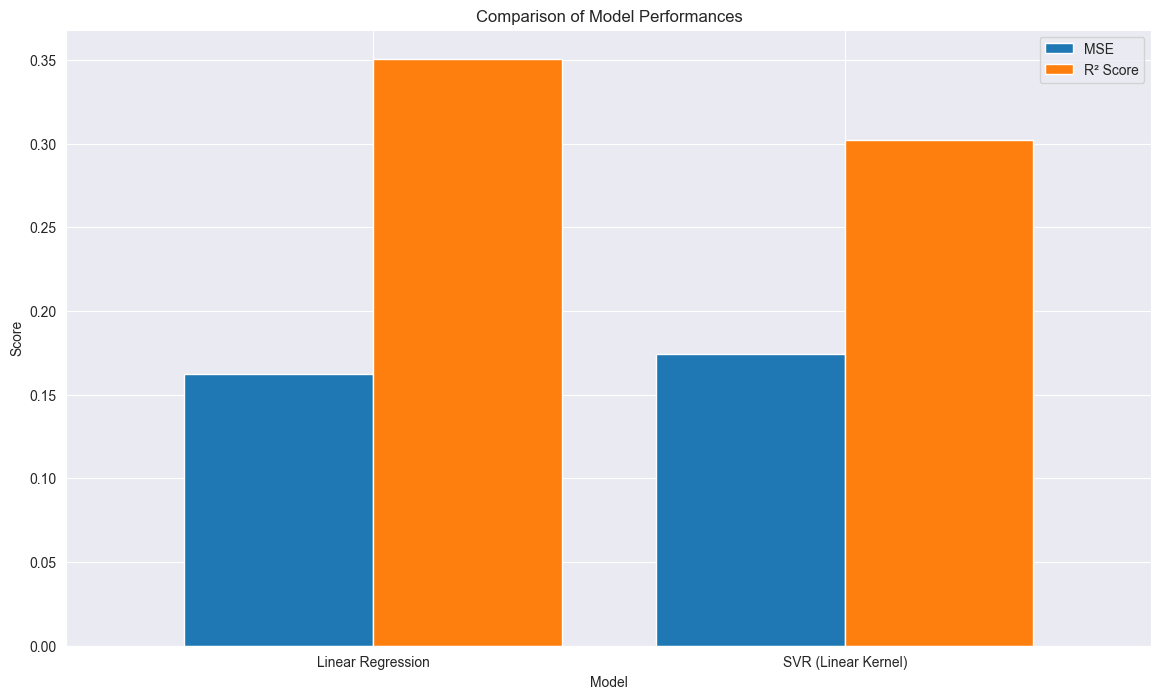

In [66]:
regression_comparison = {
    "Model": ["Linear Regression", "SVR (Linear Kernel)"],
    "MSE": [mse, mse_svr],
    "R² Score": [r2, r2_svr]
}

regression_comparison_df = pd.DataFrame(regression_comparison)

regression_comparison_df.set_index('Model').plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Comparison of Model Performances')
plt.ylabel('Score')
plt.grid(True)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

- Linear Regression shows a relatively low MSE compared to SVR, but its R² Score is also slightly lower. This suggests that the Linear Regression model may be a better choice as it strikes a balance between effectiveness and interpretability.

- SVR has a higher R² Score, but its MSE is significantly higher than that of Linear Regression, indicating that this model may not be as effective as Linear Regression in predicting target values.

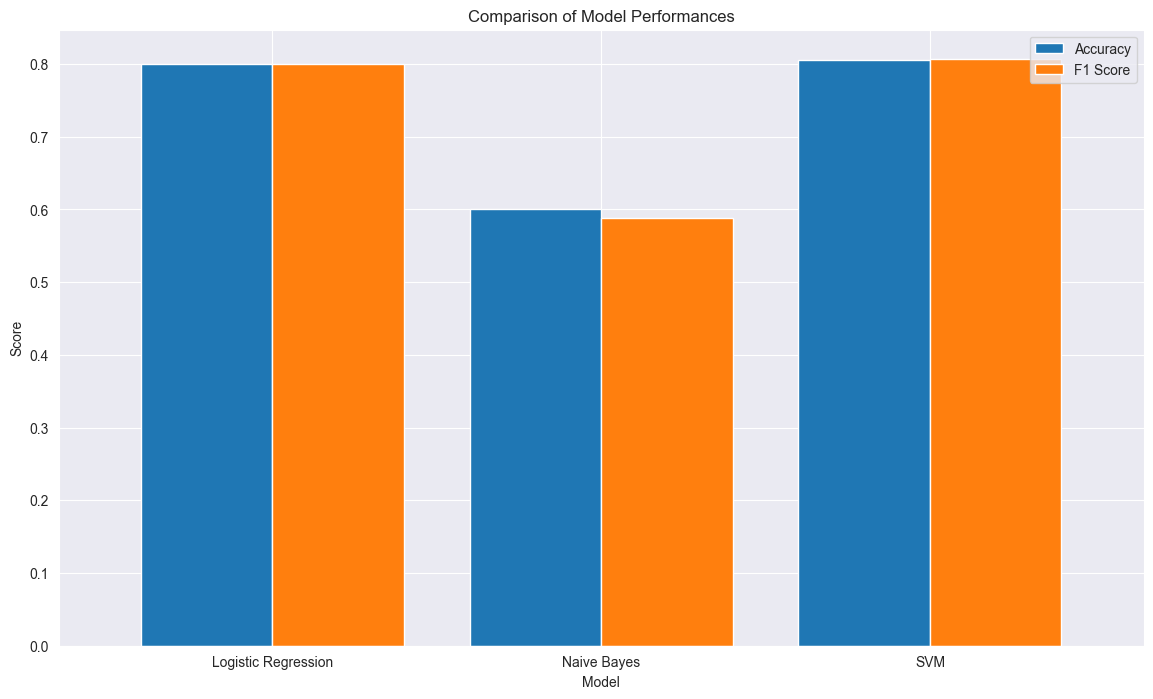

In [67]:
classification_comparison = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM'],
    'Accuracy': [accuracy_logistic, accuracy_naive_bayes, accuracy_svm], 
    'F1 Score': [f1_logistic, f1_naive_bayes, f1_svm],  
}

performance_df = pd.DataFrame(classification_comparison)

performance_df.set_index('Model').plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Comparison of Model Performances')
plt.ylabel('Score')
plt.grid(True)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

- Logistic Regression achieves both Accuracy and F1 Score at a moderate level, indicating it is a fairly balanced classification model.
- Naive Bayes has the lowest Accuracy and F1 Score among the three models, suggesting it may not be suitable for the distribution or characteristics of the data.
- SVM has a higher Accuracy than Naive Bayes, but its F1 Score is lower, indicating that while SVM may classify overall accurately, it may struggle with balanced classification between classes or accuracy issues in minority classes.

** Conclusion: **
The `Linear Regression` model seems to be the best choice for regression tasks, while `Logistic Regression` is a good choice for classification based on current data.

# **Dimensionality reduction** 

In [68]:
total_variance_retained = 0
k = 2
while total_variance_retained < 80:
    k+=1
    pca = PCA(n_components=k)
    pca.fit(X)
    # Get the variance ratio retained by principal components
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the total percentage of information retained
    total_variance_retained = sum(explained_variance_ratio) * 100
print(f"Explained variance ratio: {total_variance_retained:.02f}%")
print(f"Dimension: {k}/{len(X.columns)}")

Explained variance ratio: 80.14%
Dimension: 70/437


**Conclusion**: To retain 80% of the information, at least 70 out of 441 data dimensions need to be retained.

In [69]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)
# Get the variance ratio retained by principal components
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the total percentage of information retained
total_variance_retained = sum(explained_variance_ratio) * 100
print(f'Explained variance ratio: {total_variance_retained}')

Explained variance ratio: 21.180409939973543


### Visualize data with scatter plot

In [70]:
pca_data = pd.DataFrame(pca_data)
pca_data = pd.concat([pca_data, y], axis=1)
win_group = pca_data[pca_data['placement'] == 1]
loss_group = pca_data[pca_data['placement'] == 0]

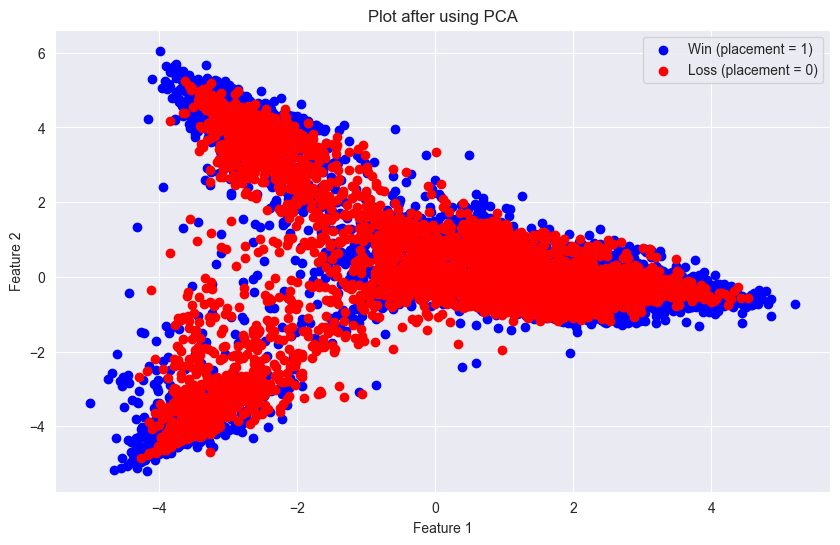

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(win_group.iloc[:, 0], win_group.iloc[:, 1], color='blue', label='Win (placement = 1)')
plt.scatter(loss_group.iloc[:, 0], loss_group.iloc[:, 1], color='red', label='Loss (placement = 0)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Plot after using PCA')
plt.legend()
plt.show()